In [ ]:
!pip install --quiet vit-keras
!pip install tensorflow_addons

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


#Using our merged dataset (train & val), alongside our given test data

This Task is task 1 (MEL VS NEVUS AND SEB). PLEASE USE APPROPRIATE PATH TO TASK1

In [ ]:
#set title for saving model 
title = "mel_vs_nev&seb_no_aug"

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
from glob import glob
import seaborn as sns
from PIL import Image
np.random.seed(123)
from sklearn.preprocessing import label_binarize
from sklearn.metrics import confusion_matrix
import itertools

import pandas as pd
import numpy as np
import keras
from keras import backend as K

import tensorflow
from tensorflow.keras.layers import Dropout, Dense, LayerNormalization, Flatten
from tensorflow.keras.activations import gelu
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

from vit_keras import vit
import tensorflow_addons as tfa
import math

import os

from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
import itertools
import shutil
import matplotlib.pyplot as plt

from zipfile import ZipFile
import time
from sklearn.model_selection import StratifiedKFold, KFold

from sklearn.metrics import roc_auc_score
from sklearn.metrics import  precision_score, recall_score, accuracy_score
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import classification_report

/usr/local/lib/python3.10/dist-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


In [ ]:
os.listdir('/content')

['.config', 'drive', 'sample_data']

In [ ]:
vit_model = vit.vit_b16(
        image_size = 224,
        activation = 'softmax',
        pretrained = True,
        include_top = False,
        pretrained_top = False,
        classes = 2)

/usr/local/lib/python3.10/dist-packages/vit_keras/utils.py:81: UserWarning: Resizing position embeddings from 24, 24 to 14, 14
  warnings.warn(


In [ ]:
# Add additional layers to the Vision Transformer

model = tensorflow.keras.Sequential([
    vit_model,
    Flatten(),
    Dense(128, activation=gelu),
    Dropout(0.1),
    LayerNormalization(epsilon=.000002),
    Dense(32, activation=gelu),
    Dropout(0.1),
    LayerNormalization(epsilon=.000002),
    Dense(2, activation='softmax')
], name='vision_transformer')



model.summary()

Model: "vision_transformer"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vit-b16 (Functional)        (None, 768)               85798656  
                                                                 
 flatten (Flatten)           (None, 768)               0         
                                                                 
 dense (Dense)               (None, 128)               98432     
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 layer_normalization (LayerN  (None, 128)              256       
 ormalization)                                                   
                                                                 
 dense_1 (Dense)             (None, 32)                4128      
                                                

In [ ]:
import tensorflow as tf
from tensorflow.keras import backend as K

def focal_loss(gamma=2, alpha=0.7):
    def focal_loss_fn(y_true, y_pred):
        y_pred = K.clip(y_pred, K.epsilon(), 1.0 - K.epsilon())
        focal_loss = -alpha * y_true * K.pow(1.0 - y_pred, gamma) * K.log(y_pred)
        return K.mean(focal_loss, axis=-1)
    return focal_loss_fn

#Compiling model using focal loss
model.compile(optimizer='adam', loss=focal_loss(), metrics=['accuracy'])

Configuring early stopping criteria and learning rate

In [ ]:
early_stopping = EarlyStopping(monitor='val_loss',patience=8)              #Early stopping criteria

def step_decay(epoch):
    initial_lrate = 0.00002                                                #Learning rate
    drop = 0.1
    epochs_drop = 10.0
    lrate = initial_lrate * math.pow(drop, math.floor((1+epoch)/epochs_drop))
    return lrate

lr_scheduler = tf.keras.callbacks.LearningRateScheduler(step_decay, verbose=1)

Function for plotting train and validation accuracy and loss

In [ ]:
def graph_it(history):
  acc = history.history['accuracy']
  val_acc = history.history['val_accuracy']
  loss = history.history['loss']
  val_loss = history.history['val_loss']
  epochs = range(len(acc))

  #Plot graph for Training and validation accuracy
  plt.plot(epochs, acc, 'r', label='Training accuracy')
  plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
  plt.title('Model Accuracy: Training and Validation')
  plt.legend(loc=0)
  plt.figure()

  #Plot graph for Training and validation loss
  plt.plot(epochs, loss, 'r', label='Training loss')
  plt.plot(epochs, val_loss, 'b', label='Validation loss')
  plt.title('Training and validation Loss')
  plt.legend(loc=0)
  plt.figure()


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, roc_auc_score, classification_report, precision_score, roc_curve, ConfusionMatrixDisplay

def test_it(model, test_generator):
    test_labels = test_generator.classes

    predictions = model.predict(test_generator)
    predicted_labels = np.argmax(predictions, axis=1)

    cm = confusion_matrix(test_labels, predicted_labels)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot()
    plt.show()

    roc = roc_auc_score(test_labels, predictions[:, 1])  # Calculating ROC Score

    # Calculate confusion matrix 
    tn, fp, fn, tp = confusion_matrix(test_labels, predicted_labels).ravel()

    # Calculate sensitivity and specificity
    sensitivity = tp / (tp + fn)
    specificity = tn / (tn + fp)

    report = classification_report(test_labels, predicted_labels)

    precision = precision_score(test_labels, predicted_labels, average='weighted')

    print("\n", report)
    print(f"Sensitivity: {round(sensitivity, 3)} Specificity: {round(specificity, 3)} Precision: {round(precision, 3)} ROC_AUC_SCORE: {round(roc, 3)}\n")

    # Plot AUC-ROC curve
    fpr, tpr, thresholds = roc_curve(test_labels, predictions[:, 1])
    plt.figure(figsize=(4, 4))
    plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc)
    plt.plot([0, 1], [0, 1], 'k--')  # Random guessing line
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    plt.show()

In [ ]:
# Set the directories for the data for task1 (MEL VS NEVUS AND SEB)
train_dir = "/content/drive/MyDrive/msc_project/train_merged/task1"
test_dir = "/content/drive/MyDrive/msc_project/test/task1"

In [ ]:
# Combine the paths and corresponding labels for the stratified k-fold
train_paths = []
train_labels = []
for class_folder in os.listdir(train_dir):
    class_path = os.path.join(train_dir, class_folder)
    if os.path.isdir(class_path):
        class_label = class_folder
        for image_filename in os.listdir(class_path):
            train_paths.append(os.path.join(class_path, image_filename))
            train_labels.append(class_label)

train_paths = np.array(train_paths)
train_labels = np.array(train_labels)

In [ ]:
# Define the data generator
datagen = ImageDataGenerator(
    preprocessing_function= \
    tensorflow.keras.applications.mobilenet.preprocess_input)

image_size = (224, 224)
batch = 10
num_fold = 5

# Initialize the stratified k-fold object
skf = StratifiedKFold(n_splits=num_fold, shuffle=True, random_state=None)

In [ ]:
model_path = f'/content/drive/MyDrive/msc_project/model/{title}'
os.makedirs(model_path, exist_ok=True)

Traning for Fold: 1
Found 1720 validated image filenames belonging to 2 classes.
Found 430 validated image filenames belonging to 2 classes.

Epoch 1: LearningRateScheduler setting learning rate to 2e-05.
Epoch 1/30
18/18 [==============================] - ETA: 0s - loss: 0.1658 - accuracy: 0.6833
Epoch 1: val_accuracy improved from -inf to 0.82000, saving model to /content/drive/MyDrive/msc_project/model/model1.hdf5
18/18 [==============================] - 110s 2s/step - loss: 0.1658 - accuracy: 0.6833 - val_loss: 0.0618 - val_accuracy: 0.8200 - lr: 2.0000e-05

Epoch 2: LearningRateScheduler setting learning rate to 2e-05.
Epoch 2/30
18/18 [==============================] - ETA: 0s - loss: 0.0931 - accuracy: 0.7167
Epoch 2: val_accuracy improved from 0.82000 to 0.84000, saving model to /content/drive/MyDrive/msc_project/model/model1.hdf5
18/18 [==============================] - 28s 2s/step - loss: 0.0931 - accuracy: 0.7167 - val_loss: 0.0413 - val_accuracy: 0.8400 - lr: 2.0000e-05

Ep

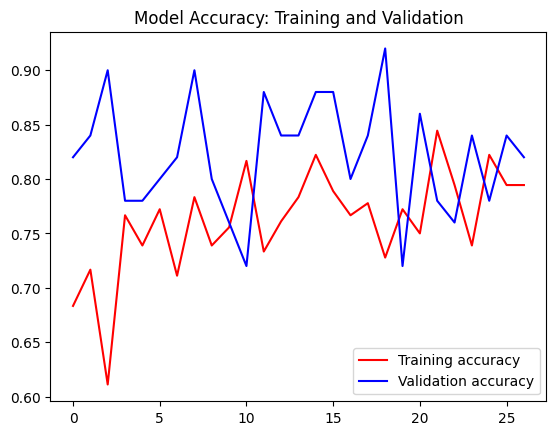

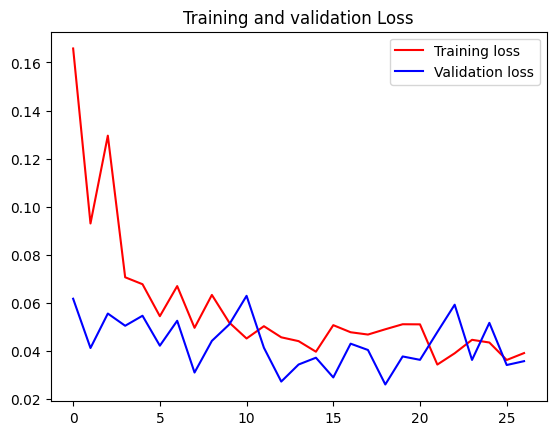

<Figure size 640x480 with 0 Axes>

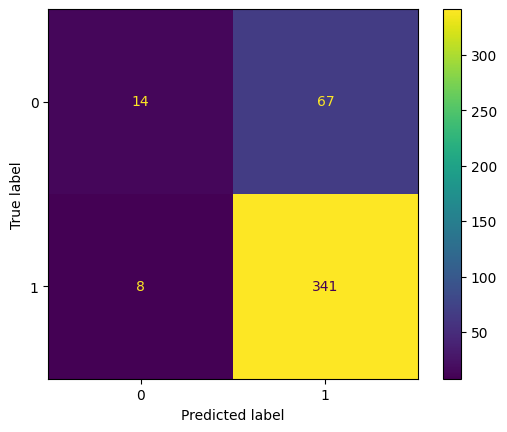


               precision    recall  f1-score   support

           0       0.64      0.17      0.27        81
           1       0.84      0.98      0.90       349

    accuracy                           0.83       430
   macro avg       0.74      0.57      0.59       430
weighted avg       0.80      0.83      0.78       430

Sensitivity: 0.977 Specificity: 0.173 Precision: 0.798 ROC_AUC_SCORE: 0.766



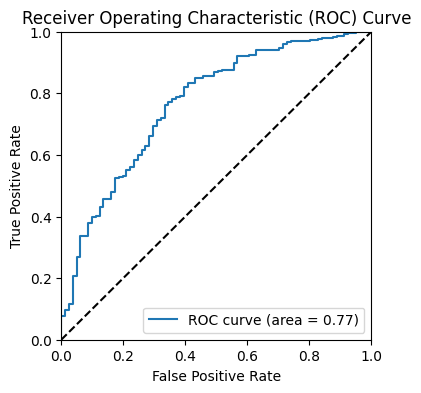

Validation complete...
Traning for Fold: 2
Found 1720 validated image filenames belonging to 2 classes.
Found 430 validated image filenames belonging to 2 classes.

Epoch 1: LearningRateScheduler setting learning rate to 2e-05.
Epoch 1/30
18/18 [==============================] - ETA: 0s - loss: 0.0527 - accuracy: 0.7611
Epoch 1: val_accuracy improved from -inf to 0.78000, saving model to /content/drive/MyDrive/msc_project/model/model2.hdf5
18/18 [==============================] - 87s 2s/step - loss: 0.0527 - accuracy: 0.7611 - val_loss: 0.0408 - val_accuracy: 0.7800 - lr: 2.0000e-05

Epoch 2: LearningRateScheduler setting learning rate to 2e-05.
Epoch 2/30
18/18 [==============================] - ETA: 0s - loss: 0.0535 - accuracy: 0.7611
Epoch 2: val_accuracy improved from 0.78000 to 0.84000, saving model to /content/drive/MyDrive/msc_project/model/model2.hdf5
18/18 [==============================] - 12s 648ms/step - loss: 0.0535 - accuracy: 0.7611 - val_loss: 0.0376 - val_accuracy: 0.

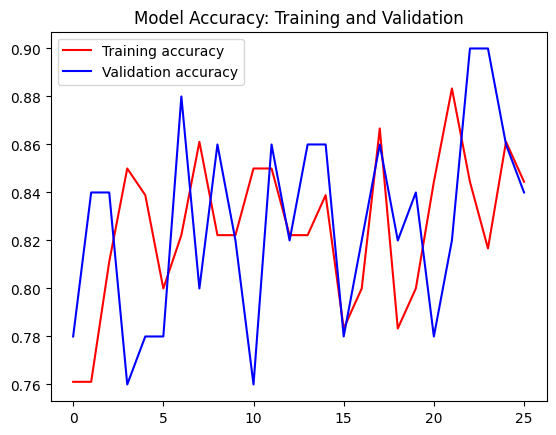

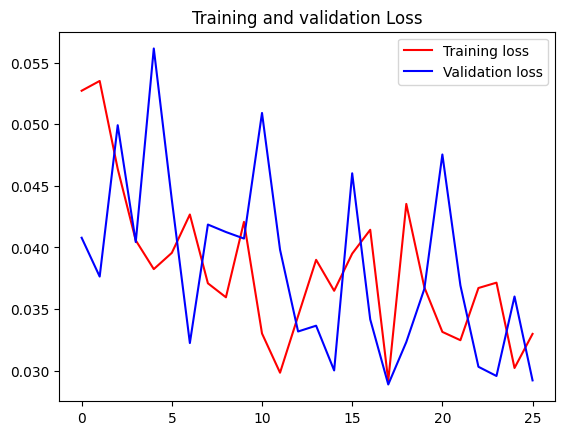

<Figure size 640x480 with 0 Axes>

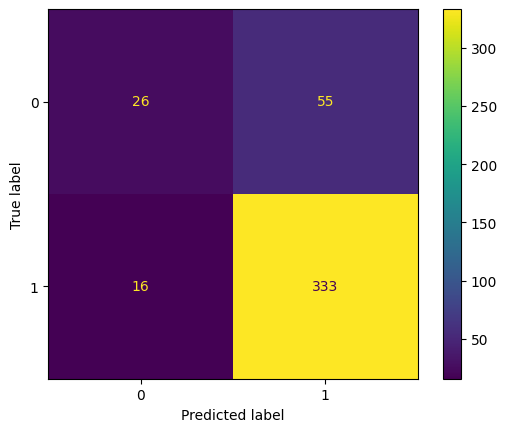


               precision    recall  f1-score   support

           0       0.62      0.32      0.42        81
           1       0.86      0.95      0.90       349

    accuracy                           0.83       430
   macro avg       0.74      0.64      0.66       430
weighted avg       0.81      0.83      0.81       430

Sensitivity: 0.954 Specificity: 0.321 Precision: 0.813 ROC_AUC_SCORE: 0.802



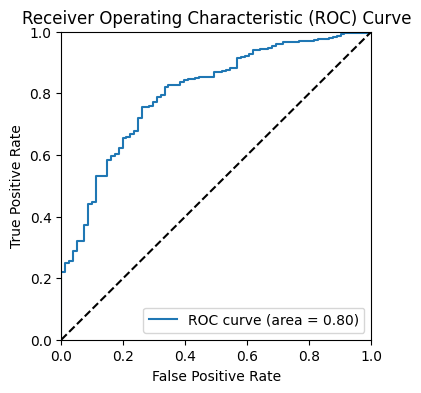

Validation complete...
Traning for Fold: 3
Found 1720 validated image filenames belonging to 2 classes.
Found 430 validated image filenames belonging to 2 classes.

Epoch 1: LearningRateScheduler setting learning rate to 2e-05.
Epoch 1/30
18/18 [==============================] - ETA: 0s - loss: 0.0413 - accuracy: 0.7778
Epoch 1: val_accuracy improved from -inf to 0.82000, saving model to /content/drive/MyDrive/msc_project/model/model3.hdf5
18/18 [==============================] - 68s 853ms/step - loss: 0.0413 - accuracy: 0.7778 - val_loss: 0.0384 - val_accuracy: 0.8200 - lr: 2.0000e-05

Epoch 2: LearningRateScheduler setting learning rate to 2e-05.
Epoch 2/30
18/18 [==============================] - ETA: 0s - loss: 0.0427 - accuracy: 0.7667
Epoch 2: val_accuracy did not improve from 0.82000
18/18 [==============================] - 10s 563ms/step - loss: 0.0427 - accuracy: 0.7667 - val_loss: 0.0387 - val_accuracy: 0.8000 - lr: 2.0000e-05

Epoch 3: LearningRateScheduler setting learning 

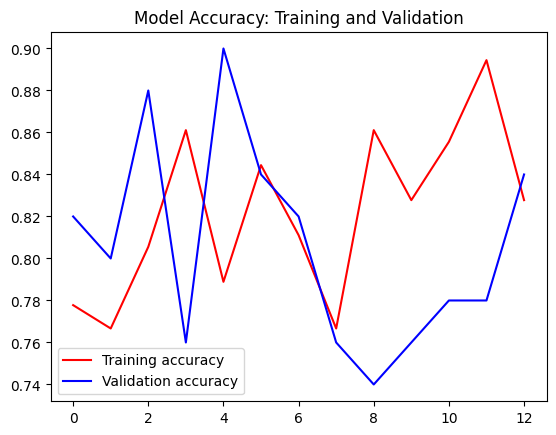

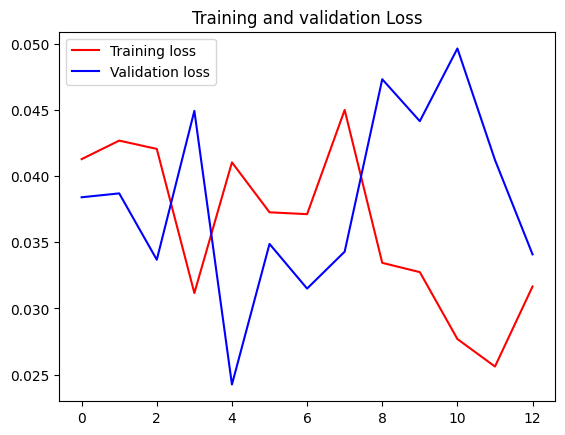

<Figure size 640x480 with 0 Axes>

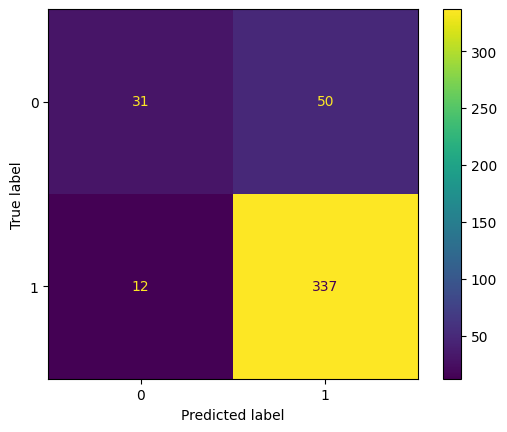


               precision    recall  f1-score   support

           0       0.72      0.38      0.50        81
           1       0.87      0.97      0.92       349

    accuracy                           0.86       430
   macro avg       0.80      0.67      0.71       430
weighted avg       0.84      0.86      0.84       430

Sensitivity: 0.966 Specificity: 0.383 Precision: 0.843 ROC_AUC_SCORE: 0.843



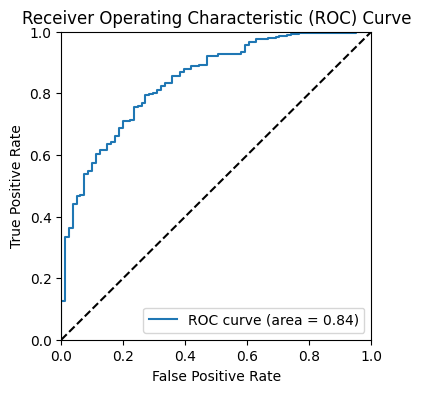

Validation complete...
Traning for Fold: 4
Found 1720 validated image filenames belonging to 2 classes.
Found 430 validated image filenames belonging to 2 classes.

Epoch 1: LearningRateScheduler setting learning rate to 2e-05.
Epoch 1/30
18/18 [==============================] - ETA: 0s - loss: 0.0405 - accuracy: 0.7889
Epoch 1: val_accuracy improved from -inf to 0.76000, saving model to /content/drive/MyDrive/msc_project/model/model4.hdf5
18/18 [==============================] - 67s 796ms/step - loss: 0.0405 - accuracy: 0.7889 - val_loss: 0.0400 - val_accuracy: 0.7600 - lr: 2.0000e-05

Epoch 2: LearningRateScheduler setting learning rate to 2e-05.
Epoch 2/30
18/18 [==============================] - ETA: 0s - loss: 0.0340 - accuracy: 0.8111
Epoch 2: val_accuracy did not improve from 0.76000
18/18 [==============================] - 10s 568ms/step - loss: 0.0340 - accuracy: 0.8111 - val_loss: 0.0459 - val_accuracy: 0.7400 - lr: 2.0000e-05

Epoch 3: LearningRateScheduler setting learning 

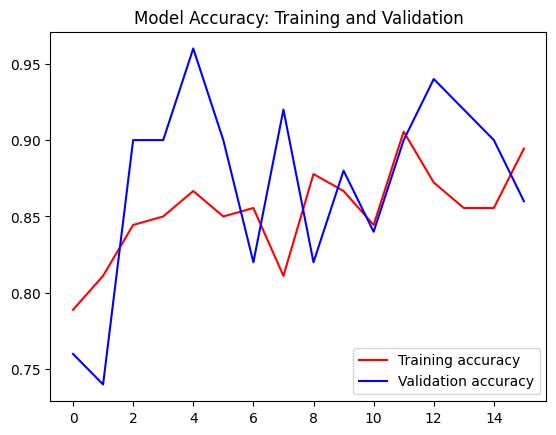

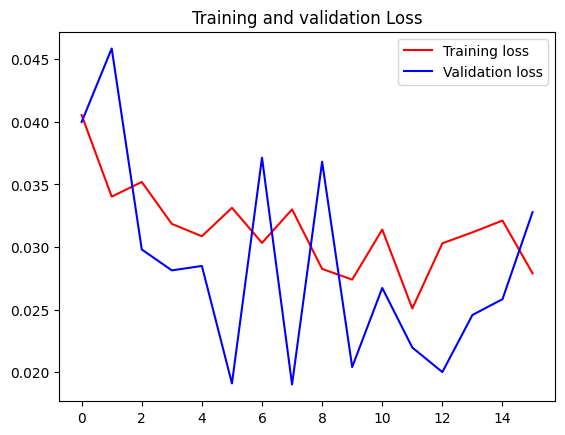

<Figure size 640x480 with 0 Axes>

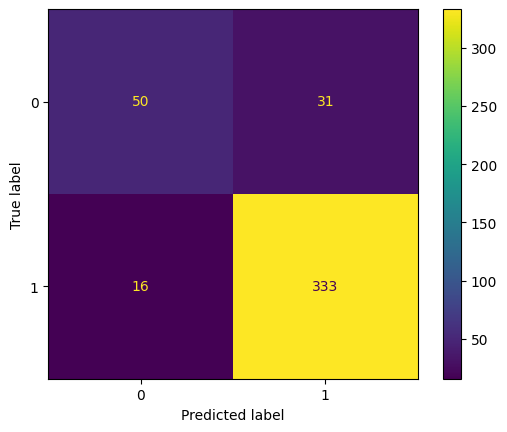


               precision    recall  f1-score   support

           0       0.76      0.62      0.68        81
           1       0.91      0.95      0.93       349

    accuracy                           0.89       430
   macro avg       0.84      0.79      0.81       430
weighted avg       0.89      0.89      0.89       430

Sensitivity: 0.954 Specificity: 0.617 Precision: 0.885 ROC_AUC_SCORE: 0.878



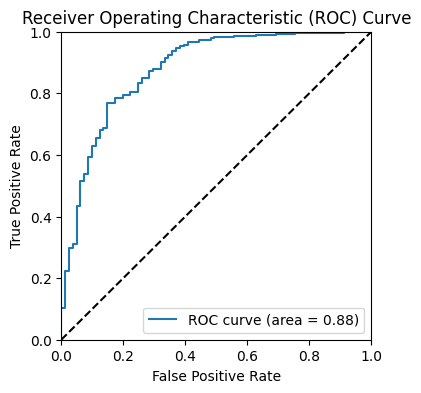

Validation complete...
Traning for Fold: 5
Found 1720 validated image filenames belonging to 2 classes.
Found 430 validated image filenames belonging to 2 classes.

Epoch 1: LearningRateScheduler setting learning rate to 2e-05.
Epoch 1/30
18/18 [==============================] - ETA: 0s - loss: 0.0327 - accuracy: 0.8556
Epoch 1: val_accuracy improved from -inf to 0.76000, saving model to /content/drive/MyDrive/msc_project/model/model5.hdf5
18/18 [==============================] - 71s 852ms/step - loss: 0.0327 - accuracy: 0.8556 - val_loss: 0.0397 - val_accuracy: 0.7600 - lr: 2.0000e-05

Epoch 2: LearningRateScheduler setting learning rate to 2e-05.
Epoch 2/30
18/18 [==============================] - ETA: 0s - loss: 0.0267 - accuracy: 0.8556
Epoch 2: val_accuracy improved from 0.76000 to 0.88000, saving model to /content/drive/MyDrive/msc_project/model/model5.hdf5
18/18 [==============================] - 13s 738ms/step - loss: 0.0267 - accuracy: 0.8556 - val_loss: 0.0267 - val_accuracy:

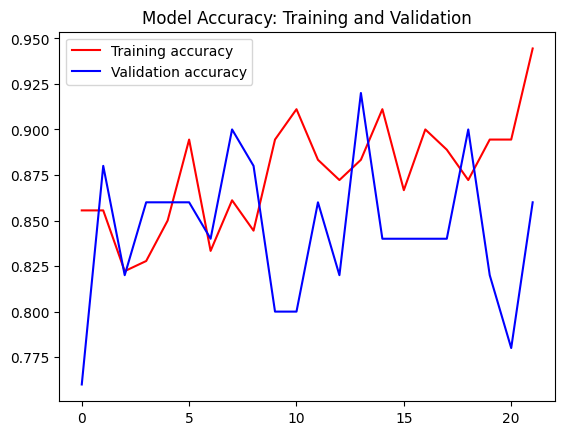

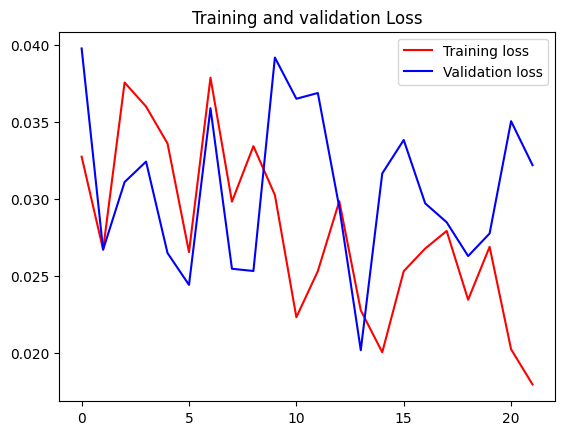

<Figure size 640x480 with 0 Axes>

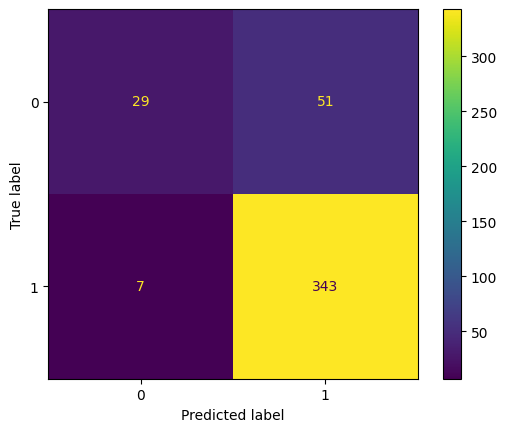


               precision    recall  f1-score   support

           0       0.81      0.36      0.50        80
           1       0.87      0.98      0.92       350

    accuracy                           0.87       430
   macro avg       0.84      0.67      0.71       430
weighted avg       0.86      0.87      0.84       430

Sensitivity: 0.98 Specificity: 0.362 Precision: 0.858 ROC_AUC_SCORE: 0.895



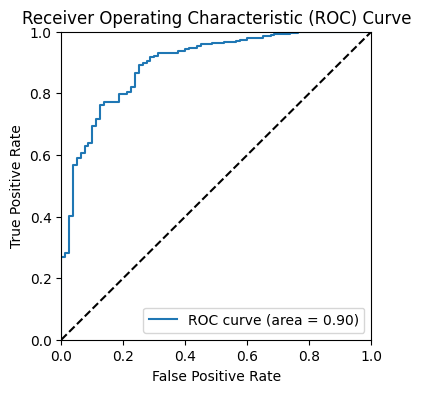

Validation complete...


In [ ]:
# Perform k-fold cross-validation
fold = 1
for i, (train_index, val_index) in enumerate(skf.split(train_paths, train_labels)):
#     print(f"Fold {i}:")
    print(f"Traning for Fold: {fold}")
    # Split the data into train and validation sets for this fold
    train_paths_fold, val_paths_fold = train_paths[train_index], train_paths[val_index]
    train_labels_fold, val_labels_fold = train_labels[train_index], train_labels[val_index]

    # Create data generators for this fold
    train_generator_fold = datagen.flow_from_dataframe(
        pd.DataFrame({'filename': train_paths_fold, 'class': train_labels_fold}),
        directory=train_dir,
        x_col='filename',
        y_col='class',
        target_size=image_size,
        batch_size=batch
    )

    val_generator_fold = datagen.flow_from_dataframe(
      pd.DataFrame({'filename': val_paths_fold, 'class': val_labels_fold}),
      directory=train_dir,
      x_col='filename',
      y_col='class',
      target_size=image_size,
      batch_size=batch
  )


    train_steps = np.ceil(len(train_generator_fold) / batch)
    val_steps = np.ceil(len(val_generator_fold) / batch)

    #set path to save model
    checkpointer = tf.keras.callbacks.ModelCheckpoint(filepath = model_path + f'/model_fold_{fold}.hdf5',
                                                  monitor = 'val_accuracy',
                                                  verbose = 1,
                                                  save_best_only = True,
                                                  save_weights_only = True,
                                                  mode = 'max')

    callbacks = [early_stopping, checkpointer, lr_scheduler]


    # Compile the model
    model.compile(
        optimizer='adam',
        loss=focal_loss(),
        metrics=['accuracy']
    )

    # Train the model on the training data and evaluate on the validation data
    history = model.fit(
        train_generator_fold,
        steps_per_epoch=train_steps,
        validation_data=val_generator_fold,
        validation_steps=val_steps,
        epochs=30,
        callbacks=callbacks)

    graph_it(history)


    val_generator_fold_test = datagen.flow_from_dataframe(
        pd.DataFrame({'filename': val_paths_fold, 'class': val_labels_fold}),
        directory=train_dir,
        x_col='filename',
        y_col='class',
        target_size=image_size,
        batch_size=1,
        shuffle=False
    )

    print(f"\nValidating for fold {fold}... \n")
    print("Loading model...")

    model.load_weights(filepath = model_path + f'/model_fold_{fold}.hdf5')
    test_it(model, val_generator_fold_test)

    print("Validation complete...")

    fold += 1


**Model Evaluation using test data**

In [ ]:
test_dir

'/content/drive/MyDrive/msc_project/test/task1'

In [ ]:
test_generator = datagen.flow_from_directory(
        test_dir,
        target_size=image_size,
        batch_size=1,
        shuffle=False
    )
test_generator.shuffle = False

Found 600 images belonging to 2 classes.


600/600 [==============================] - 32s 45ms/step


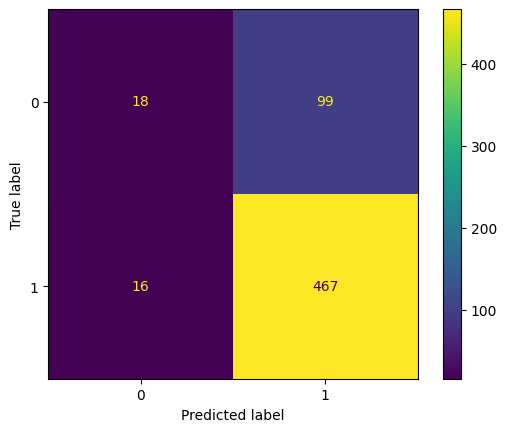


               precision    recall  f1-score   support

           0       0.53      0.15      0.24       117
           1       0.83      0.97      0.89       483

    accuracy                           0.81       600
   macro avg       0.68      0.56      0.56       600
weighted avg       0.77      0.81      0.76       600

Sensitivity: 0.967 Specificity: 0.154 Precision: 0.767 ROC_AUC_SCORE: 0.701



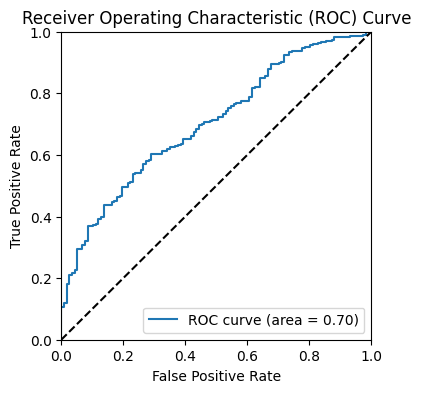

In [ ]:
model.load_weights(filepath = f'/content/drive/MyDrive/msc_project/model/model1.hdf5')

test_it(model, test_generator)

Model 2

600/600 [==============================] - 28s 47ms/step


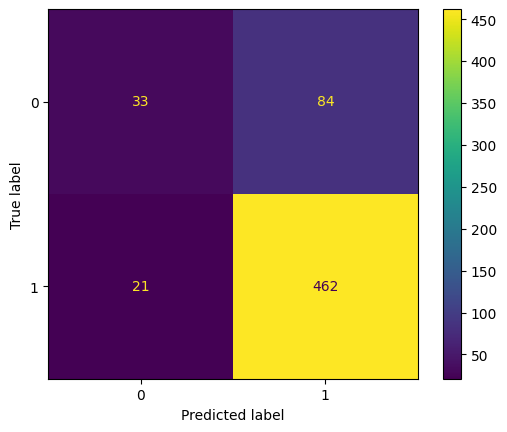


               precision    recall  f1-score   support

           0       0.61      0.28      0.39       117
           1       0.85      0.96      0.90       483

    accuracy                           0.82       600
   macro avg       0.73      0.62      0.64       600
weighted avg       0.80      0.82      0.80       600

Sensitivity: 0.957 Specificity: 0.282 Precision: 0.8 ROC_AUC_SCORE: 0.787



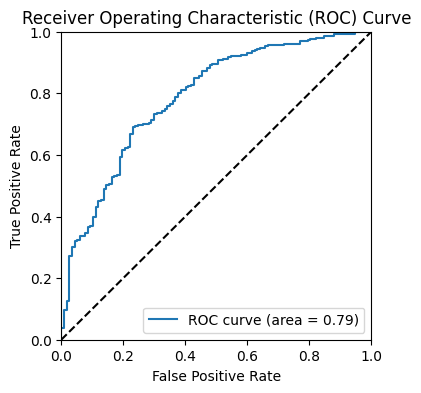

In [ ]:
model.load_weights(filepath = f'/content/drive/MyDrive/msc_project/model/model2.hdf5')
test_it(model, test_generator)

Model 3

600/600 [==============================] - 28s 46ms/step


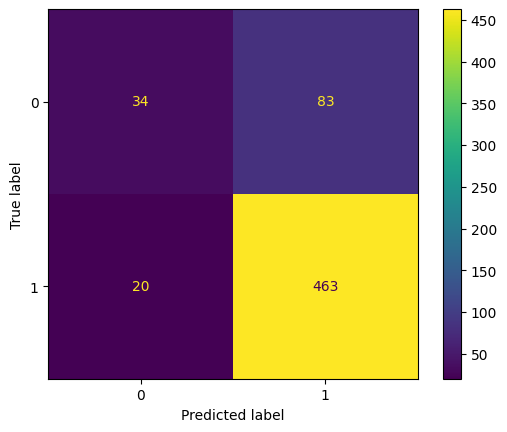


               precision    recall  f1-score   support

           0       0.63      0.29      0.40       117
           1       0.85      0.96      0.90       483

    accuracy                           0.83       600
   macro avg       0.74      0.62      0.65       600
weighted avg       0.81      0.83      0.80       600

Sensitivity: 0.959 Specificity: 0.291 Precision: 0.805 ROC_AUC_SCORE: 0.788



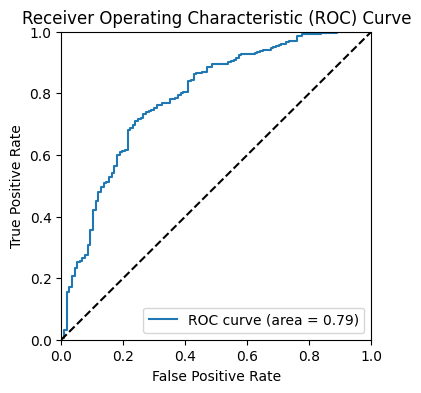

In [ ]:
model.load_weights(filepath = f'/content/drive/MyDrive/msc_project/model/model3.hdf5')
test_it(model, test_generator)


Model 4

600/600 [==============================] - 27s 45ms/step


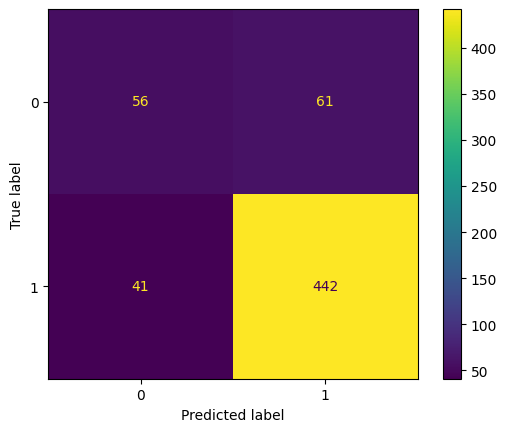


               precision    recall  f1-score   support

           0       0.58      0.48      0.52       117
           1       0.88      0.92      0.90       483

    accuracy                           0.83       600
   macro avg       0.73      0.70      0.71       600
weighted avg       0.82      0.83      0.82       600

Sensitivity: 0.915 Specificity: 0.479 Precision: 0.82 ROC_AUC_SCORE: 0.806



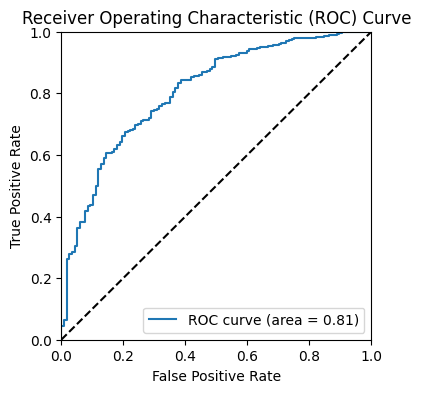

In [ ]:
model.load_weights(filepath = f'/content/drive/MyDrive/msc_project/model/model4.hdf5')
test_it(model, test_generator)

Model 5

600/600 [==============================] - 27s 44ms/step


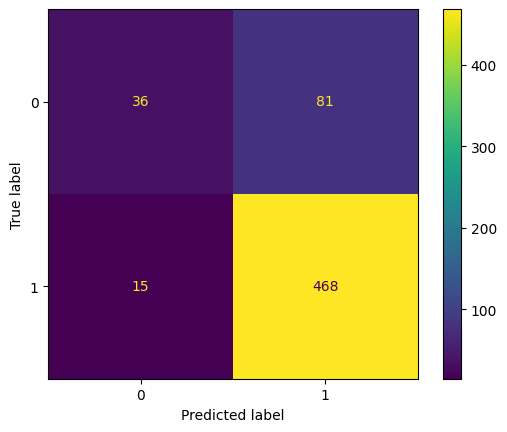


               precision    recall  f1-score   support

           0       0.71      0.31      0.43       117
           1       0.85      0.97      0.91       483

    accuracy                           0.84       600
   macro avg       0.78      0.64      0.67       600
weighted avg       0.82      0.84      0.81       600

Sensitivity: 0.969 Specificity: 0.308 Precision: 0.824 ROC_AUC_SCORE: 0.808



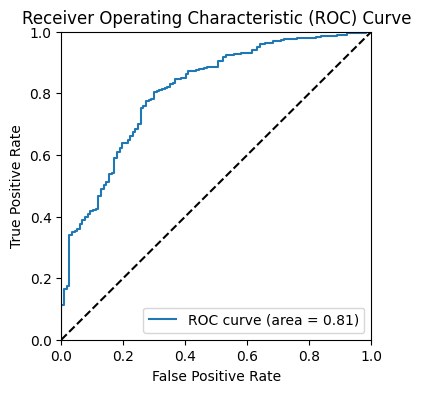

In [ ]:
model.load_weights(filepath = f'/content/drive/MyDrive/msc_project/model/model5.hdf5')
test_it(model, test_generator)